# Title NN classifier for Political Bias

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

batch_size = 64

In [2]:
df = pd.read_csv("../data/source/newsclust.csv")
df = df.query("site != 'cbn.com'")
print(len(df))
df = df.sample(90000)

103262


Compute the bias for each one of the articles, based on the publication's known bias

In [3]:
from bias import Bias

num_classes = 7
df['bias'] = df.apply(lambda row: Bias.get_bias_for_domain(row['site']).value, axis=1)
df.head(2)

,Unnamed: 0,date,site,text,title,url,bias
42164,42164,2015-06-03T17:07:00.000+03:00,azcentral.com,Arizona Department of Public Safety officers s...,"DPS rescues hiker without food, water for 3 days",http://www.azcentral.com/story/news/local/ariz...,4
32568,32568,2015-04-30T00:22:00.000+03:00,nj.com,Comments The Lebanon Township School District ...,"Parents, teachers voice concerns over cuts in ...",http://www.nj.com/hunterdon-county-democrat/in...,2


Tokenize the text of the articles, create a vocabulary of words

In [4]:
import spacy
nlp = spacy.load('en')
nlp.pipeline = []

def tokenize_text(texts):
    docs = [doc for doc in nlp.pipe(texts, batch_size=500, n_threads=8)]
    return docs

def is_invalid_token(token):
    return token.is_punct or token.is_space or token.like_url or token.like_num or token.is_digit

def get_words_for_docs(docs):
    return [get_words_ids(doc) for doc in docs]

def get_words_ids(doc):
    return [token.orth for token in doc if not is_invalid_token(token)]

In [5]:
df['docs'] = tokenize_text(df['title'].astype(str))

In [6]:
df['words'] = get_words_for_docs(df['docs'])
df.head(1)

,Unnamed: 0,date,site,text,title,url,bias,docs,words
42164,42164,2015-06-03T17:07:00.000+03:00,azcentral.com,Arizona Department of Public Safety officers s...,"DPS rescues hiker without food, water for 3 days",http://www.azcentral.com/story/news/local/ariz...,4,"(DPS, rescues, hiker, without, food, ,, water,...","[544831, 182434, 123302, 845, 1296, 1334, 531,..."


Keep the most common words as vocabulary, replace the words out of vocabulary by the least frequently used word

In [7]:
from collections import Counter

vocab_size = 100000

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

word_freq = Counter(flatten(df['words']))
common_words = word_freq.most_common(vocab_size)
word_freq.most_common(5)

[(504, 18201), (576246, 14785), (522, 12742), (566, 11629), (501, 11600)]

In [8]:
print(nlp.vocab.strings[501], nlp.vocab.strings[510], nlp.vocab.strings[512], nlp.vocab.strings[506])

the of and a


In [9]:
vocab = {word_id: i for (i, (word_id, freq)) in enumerate(common_words)}
print(len(vocab), vocab[501], vocab[504], vocab[510])
oov_word = vocab_size - 1
oov_word

66064 4 0 5


99999

In [10]:
def get_words_ids_if_common(words):
    return [vocab.get(word, oov_word) for word in words]

df['words_with_oov'] = df.apply(lambda row: get_words_ids_if_common(row['words']), axis=1)
df['words_with_oov'].head()

42164       [17711, 8011, 20637, 1326, 1510, 1024, 7, 1260]
32568     [934, 5293, 4972, 3056, 77, 1526, 2, 8988, 412...
84295     [78, 480, 544, 45, 14058, 3605, 20638, 1916, 2...
11957     [16, 15, 167, 1150, 9, 275, 1327, 150, 73, 638...
101327     [731, 8989, 10114, 8462, 6381, 1597, 2, 10, 809]
Name: words_with_oov, dtype: object

Look at the distribution of words. The longest article has 15K words, the shortest 21.

In [11]:
lens = np.array(list(map(len, df['words'])))
(lens.max(), lens.min(), lens.mean())

(45, 0, 11.1021)

Split the data for training and validation

In [12]:
TEST_DOMAINS =  {
    'bloomberg.com',
     'breitbart.com',
     'c-span.org',
     'chicagotribune.com',
     'chron.com'
}
df_train =  df.loc[~df['site'].isin(TEST_DOMAINS)]
df_test =  df.loc[df['site'].isin(TEST_DOMAINS)]
print(len(df_train))
print(len(df_test))

82383
7617


Enforce all texts to have the same length, truncating or padding if necessary

In [13]:
seq_len = 50

from keras.preprocessing import sequence

trn = sequence.pad_sequences(df_train['words_with_oov'], maxlen=seq_len, value=0)
test = sequence.pad_sequences(df_test['words_with_oov'], maxlen=seq_len, value=0)

trn

Using TensorFlow backend.


array([[    0,     0,     0, ...,  1024,     7,  1260],
       [    0,     0,     0, ...,     9,  4230,  1136],
       [    0,     0,     0, ...,    10,   460,  5110],
       ..., 
       [    0,     0,     0, ...,    20,     3,   292],
       [    0,     0,     0, ..., 19156,    10, 66063],
       [    0,     0,     0, ...,   173,  1027,  4286]], dtype=int32)

## Single Hidden Layer NN classifier

### Keras NN model

In [14]:
# Force use CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Convolution1D, MaxPooling1D
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import Adam

In [15]:
k_model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')])

In [16]:
k_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
#k_model.summary()

In [17]:
from keras.utils.np_utils import to_categorical

labels_train = np.array(df_train['bias'])
labels_test = np.array(df_test['bias'])

k_model.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=2, batch_size=batch_size)

/home/ubuntu/pytorch/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 82383 samples, validate on 7617 samples
Epoch 1/2
82383/82383 [==============================] - 72s - loss: 1.3093 - acc: 0.4827 - val_loss: 1.1588 - val_acc: 0.5598
Epoch 2/2
82383/82383 [==============================] - 72s - loss: 0.7689 - acc: 0.7228 - val_loss: 1.2821 - val_acc: 0.4839


Manually verify some articles. The bias for these articles should match the predicted bias below.

In [18]:
df_sample = df_test.sample(5)
df_sample[['site', 'title', 'bias']]

,site,title,bias
30315,c-span.org,2015 Youth Violence Prevention Summit | Video ...,3
63740,breitbart.com,Glenn Beck Sues Former TheBlaze CEO in Texas C...,5
74117,breitbart.com,Concerns Grow About Tunisia's Stability amid E...,5
96114,chron.com,Lightning-Blue Jackets Sums - Houston Chronicle,2
93439,bloomberg.com,AISIN SEIKI CO LTD (7259:Tokyo Stock Exchange)...,2


In [19]:
sample = sequence.pad_sequences(df_sample['words_with_oov'], maxlen=seq_len, value=0)
prediction = np.argmax(k_model.predict(test), axis=1)
print("precision = ", np.sum(prediction == labels_test) * 100.0 / len(labels_test))
df_prediction, df_prediction['bias'] = df_sample[['site', 'title']], np.argmax(k_model.predict(sample), axis=1)
df_prediction

precision =  48.3917552842


/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,site,title,bias
30315,c-span.org,2015 Youth Violence Prevention Summit | Video ...,4
63740,breitbart.com,Glenn Beck Sues Former TheBlaze CEO in Texas C...,5
74117,breitbart.com,Concerns Grow About Tunisia's Stability amid E...,2
96114,chron.com,Lightning-Blue Jackets Sums - Houston Chronicle,2
93439,bloomberg.com,AISIN SEIKI CO LTD (7259:Tokyo Stock Exchange)...,5


In [21]:
cm = confusion_matrix(labels_test, prediction)
cm

array([[   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [  11,  272, 2950,  337,  999,  387,   32],
       [   3,   39,  205,  180,  569,   32,    5],
       [   0,    0,    0,    0,    0,    0,    0],
       [   5,  615,  213,   11,   81,  556,  115],
       [   0,    0,    0,    0,    0,    0,    0]])

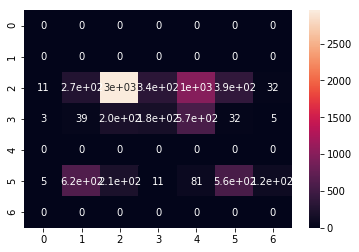

In [23]:
sn.heatmap(cm, annot=True)

## CNN with MaxPool NN classifier

In [24]:
conv1 = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(32, 5, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')])

conv1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# conv1.summary()

/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 5, activation="relu", padding="same")`
  after removing the cwd from sys.path.


In [25]:
conv1.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=3, batch_size=batch_size)

/home/ubuntu/pytorch/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 82383 samples, validate on 7617 samples
Epoch 1/3
82383/82383 [==============================] - 81s - loss: 1.3428 - acc: 0.4647 - val_loss: 1.2082 - val_acc: 0.5763
Epoch 2/3
82383/82383 [==============================] - 81s - loss: 0.9170 - acc: 0.6580 - val_loss: 1.2014 - val_acc: 0.5171
Epoch 3/3
82383/82383 [==============================] - 81s - loss: 0.6969 - acc: 0.7512 - val_loss: 1.4967 - val_acc: 0.4595


In [26]:
predictions = np.argmax(conv1.predict(test), axis=1)
print("precision = ", np.sum(predictions == labels_test) * 100.0 / len(labels_test))
df_prediction, df_prediction['bias'] = df_sample[['site', 'title']], np.argmax(conv1.predict(sample), axis=1)
df_prediction

precision =  45.9498490219


/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,site,title,bias
30315,c-span.org,2015 Youth Violence Prevention Summit | Video ...,2
63740,breitbart.com,Glenn Beck Sues Former TheBlaze CEO in Texas C...,5
74117,breitbart.com,Concerns Grow About Tunisia's Stability amid E...,2
96114,chron.com,Lightning-Blue Jackets Sums - Houston Chronicle,2
93439,bloomberg.com,AISIN SEIKI CO LTD (7259:Tokyo Stock Exchange)...,4


In [27]:
cm = confusion_matrix(labels_test, predictions)
cm

array([[   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [  13,  454, 2774,  234, 1038,  461,   14],
       [   1,   65,  666,   46,  139,  114,    2],
       [   0,    0,    0,    0,    0,    0,    0],
       [  10,  618,  154,    5,   61,  680,   68],
       [   0,    0,    0,    0,    0,    0,    0]])

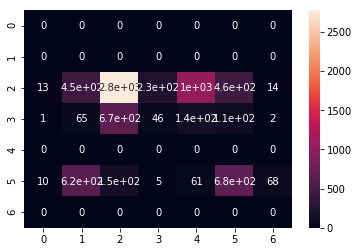

In [28]:
sn.heatmap(cm, annot=True)

## Multi-size CNN

This gives the best performance at around 60% accuracy

In [29]:
from keras.layers import Merge, Input

graph_in = Input ((vocab_size, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = Merge(mode="concat")(convs) 
graph = Model(graph_in, out)

/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", padding="same")`
  
/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 4, activation="relu", padding="same")`
  
/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 5, activation="relu", padding="same")`
  
/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # Remove the CWD from sys.path while we load stuff.


In [30]:
multi_size_cnn = Sequential ([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2),
    Dropout (0.3),
    graph,
    Dropout (0.5),
    Dense (100, activation="relu"),
    Dropout (0.3),
    Dense (7, activation='softmax')
    ])

multi_size_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
# conv1.summary()

/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  


In [31]:
multi_size_cnn.fit(trn, labels_train, validation_data=(test, labels_test), nb_epoch=3, batch_size=batch_size)

/home/ubuntu/pytorch/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 82383 samples, validate on 7617 samples
Epoch 1/3
82383/82383 [==============================] - 198s - loss: 1.2664 - acc: 0.4962 - val_loss: 1.3434 - val_acc: 0.4810
Epoch 2/3
82383/82383 [==============================] - 196s - loss: 0.8837 - acc: 0.6716 - val_loss: 1.4418 - val_acc: 0.4468
Epoch 3/3
82383/82383 [==============================] - 195s - loss: 0.6699 - acc: 0.7570 - val_loss: 1.5885 - val_acc: 0.4432


In [32]:
predictions = np.argmax(multi_size_cnn.predict(test), axis=1)
print("precision = ", np.sum(predictions == labels_test) * 100.0 / len(labels_test))
df_prediction, df_prediction['bias'] = df_sample[['site', 'title']], np.argmax(multi_size_cnn.predict(sample), axis=1)
df_prediction

precision =  44.3219115137


/home/ubuntu/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,site,title,bias
30315,c-span.org,2015 Youth Violence Prevention Summit | Video ...,4
63740,breitbart.com,Glenn Beck Sues Former TheBlaze CEO in Texas C...,5
74117,breitbart.com,Concerns Grow About Tunisia's Stability amid E...,4
96114,chron.com,Lightning-Blue Jackets Sums - Houston Chronicle,2
93439,bloomberg.com,AISIN SEIKI CO LTD (7259:Tokyo Stock Exchange)...,2


In [33]:
cm = confusion_matrix(labels_test, predictions)
cm

array([[   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [  14,  358, 2759,  415, 1074,  326,   42],
       [   3,   53,  189,   70,  694,   16,    8],
       [   0,    0,    0,    0,    0,    0,    0],
       [   9,  593,  171,   11,  100,  547,  165],
       [   0,    0,    0,    0,    0,    0,    0]])

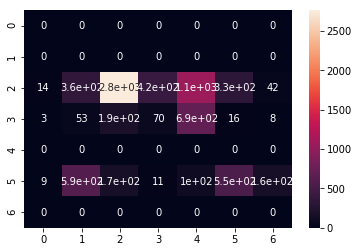

In [34]:
sn.heatmap(cm, annot=True)

## Site vectors

Remove the last linear classifier

In [35]:
l4 = k_model.pop()
l3 = k_model.pop()

In [36]:
k_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
k_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            3200000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                80050     
Total params: 3,280,050
Trainable params: 3,280,050
Non-trainable params: 0
_________________________________________________________________


In [37]:
article_vectors = k_model.predict(trn)
article_vectors.shape

(82383, 50)

Generate an average vector of all the article vectors for each site

In [38]:
site_vectors = []
labels = []
sample_size = 1000
for site in df_train['site'].unique():
    site_indexes = np.where(df_train["site"] == site)[0]
    if len(site_indexes) > 0:
        site_vector = np.mean(article_vectors[site_indexes[:sample_size], :], axis=0)
        site_vectors.append(site_vector)
        labels.append(site)
site_vectors = np.array(site_vectors)
site_vectors.shape

(57, 50)

In [39]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
site_vectors_2_dim = tsne_model.fit_transform(site_vectors)
X_proj = site_vectors_2_dim[:, 0]
Y_proj = site_vectors_2_dim[:, 1]

In [40]:
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from plotly.graph_objs import Bar, Scatter, Figure, Layout, XAxis, YAxis

In [41]:
trace = Scatter(x=X_proj, y=Y_proj, mode='markers+text', text=labels, textposition='top',  marker=dict(size=10))
iplot({
    'data': [trace],
    'layout': Layout(
        #xaxis=XAxis(title='Left vs Right'), 
        #yaxis=YAxis(title='Biased vs Factual'),
        autosize=False,
        width=1000,
        height=700)},
    show_link=False
)

### PCA Analysis

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
site_vectors_pca = pca.fit(site_vectors).components_

In [43]:
trace = Scatter(x=site_vectors_pca[0], y=site_vectors_pca[1], mode='markers+text', text=labels, textposition='top',  marker=dict(size=10))
iplot({
    'data': [trace],
    'layout': Layout(
        #xaxis=XAxis(title='Left vs Right'), 
        #yaxis=YAxis(title='Biased vs Factual'),
        autosize=False,
        width=1000,
        height=700)},
    show_link=False
)